# Time to finish the model 
### [RN] Feb 10, 2021 1:45 pm 

Time to finish up the model by fitting initial conditions for my SIRHD model to the real data. Then I will pass it to Katherine, who has been doing research by reading publications, and she will work on error analysis. 

I will copy and paste my code for the extended SIR and the data extraction from the Neher Lab set below from previoius notebooks. 

I will summarize all the differentials I am using below. 

$\frac{dS(t)}{dt} = -k\frac{S(t)}{N}I(t) - v(t)\left(\frac{S(t)}{R(t) + S(t)}\right) + \frac{1}{w}R(t)$

The susceptible group (S) is people who have not been infected, plus people who were infected w days ago and thus lost temporary immunity, minus dead people, minus people who have been vaccined. 

$\frac{dI(t)}{dt} = k\frac{S(t)}{N}I(t)-gI(t)$

Infected people is found assuming each infected person infeacts k new people per day, minus removing people as recovered assuming it takes T days to recover, with $g = \frac{1}{T}$. 

$\frac{dR(t)}{dt} = gI(t)-D(t)-v(t)\left(\frac{R(t)}{R(t) + S(t)}\right) - \frac{1}{w}R(t)$

Recovered people is the recoverd group based on taking g days since infection to recover minus vaccinated people, minus dead people. 

$\frac{dH(t)}{dt} = \begin{cases}
    H(t) + v(t)\left(R(t) + S(t)\right), & t > lag \\
    0, & t < lag
    \end{cases}$ 

H is the immune herd, or vaccinated group. People who are recovered (with temporary immunity for w days), and who are susceptible are given equal probability of recieving a vaccine. Assuming the vaccine rate ramps up in a logarithmic fashion, with v being a tunable constant. It is also assumed that there is some number of days (lag) into the epidemic in which there is no vaccine. Vaccination is introduced after lag days have passed. Once a person is vaccinated, they are permanently in the H group. 


$v(t) = v\left(\frac{t}{r+x}\right)$

Vaccines are dispersed at a rate which exponentially increases then reaches steady state. "r" is an input arguement which is the number of days it takes for the vaccine adminstration to reach half of eventual maximum capacity, and "v" is the maximum capacity. 


$\frac{dD(t)}{dt} = dI(t)$ 

Dead people are calculated by assuming that "d" percent of every infected person will pass away. 

We will be trying to find a HIT point (herd immunity threshhold), which will be the point at which the H population reaches a point at which the rate of infections changes to go down and the probability of the epidemic severity reaching another local maximum is next to none. 


In [22]:
def SIR(I0, N, k, g, dt, duration):
    j = int(duration/dt)
    time_elapsed = 0 # go for duration, iterating by dt
    I, S, R = np.zeros(j), np.zeros(j), np.zeros(j) # i will iterate and fill these in with values 
    R[0] = g*I0 # set initial values as given. 
    I[0] = I0
    S[0] = N-1
    for i in range(1, j): # increment SIR by dt. eg X(t+dt) = X(t) + dX. Log totals in the arrays. 
        dR = g*I[i-1]*dt # get dX values from equation 6
        dI = ((k/N)*S[i-1]*I[i-1]-g*I[i-1])*dt
        dS = -(k/N) * S[i-1]*I[i-1]*dt
        I[i] = I[i-1]+dI  # add increment to last value X(t) to get X(t+dt)
        R[i] = R[i-1]+dR
        S[i] = S[i-1]+dS
    return S, I, R   # return S, I, and R arrays indexed by time.

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.stats as stats

In [24]:
### code from 20210202_TuesdayMeeting to get raw data into arrays. 

def ReadFile(infile): # read infile, return contents list of each line
    read = open(infile, 'r')
    lines = read.readlines()
    read.close()
    return(lines)
# read raw data
raw = ReadFile("USA-California.tsv")

def TryFloat(val): # I want to convert nonempty data points to either floats or none so I can operate on these arrays. 
    try:
        val = float(val)
    except:
        val = None
    return val
        
# extract data 
date, cases, deaths, hospital, icu, recovered = [], [], [], [], [], []

for i in range(4, len(raw)): # split up raw data. it looks like there are bytes  b'\t' that seprate vals in addition to end characters. 
    thisset = raw[i]
    thisset = thisset.encode('utf-8') # encode data as bytes
    working = thisset.split(b'\t') # split data by byte
    for i in range(len(working)):
        working[i] = working[i].decode('utf8', 'strict') # put back as string for easier handling 
    date.append(working[0])
    cases.append(TryFloat(working[1]))
    deaths.append(TryFloat(working[2]))
    hospital.append(TryFloat(working[3]))
    icu.append(TryFloat(working[4]))
    recovered.append(working[5])


In [25]:
## final function. 

"""
Input arguements 
I0 : initial number of infected peopl e
N : population size 
k : number of people each infected person infects 
g : removal rate from infectious pool 
v : maximum number of vaccines that will be given per day, limited by manufacturing and dispersal (after development)
lag : Number of days after patient 0, or day 0, after which vaccine becomes available
A : Anti vax population, or a percent of the population that will refuse the vaccine 
d : death rate, or percept of recovered people who are actually dead and removed completely 
w : number of days after infection that a person is temporarily immune and in recovered pool before being moved back to susceptible
r : number of days it takes to rollout vaccine at half maximum capacity
dt : time step. this is moderately sensitive to time step, see 20210205 notebook 
duration : number of days that should be modeled 

Outputs (arrays indexed by time): 
S : population susceptible to infection, and viable for vaccination 
I : Infected population 
R : recovered population, temporarily immine and viable for vaccination 
H : immune population, shows herd immunity through vaccination. Once vaccinated you are permanently immune by this extension
D : Dead population 
"""
def SIRHD(I0, N, k, g, v, lag, r, A, d, w, dt, duration): # susceptible, infected, temporarily immune, dead, herd immune
    j = int(duration/dt)
    time_elapsed = 0 # go for duration, iterating by dt
    I, S, R, H, D = np.zeros(j), np.zeros(j), np.zeros(j), np.zeros(j), np.zeros(j) # i will iterate and fill these in with values 
    IPD = np.zeros(j) # infected per day
    R[0] = 0 # set initial values as given. 
    I[0] = I0
    S[0] = N-I0
    H[0] = 0 # starts with no people vaccinated
    D[0] = 0
    IPD[0] = 0
    for i in range(1, j): # increment SIR by dt. eg X(t+dt) = X(t) + dX. Log totals in the arrays. 
        dR = g*I[i-1]*dt - (1/w)*R[i-1] * dt # get dX values from equation 6
        dI = ((k/N)*S[i-1]*I[i-1]-g*I[i-1])*dt
        if i*dt > lag:  # introduce number of days into pandemic it takes to get vaccinations going 
            since_vacc = i*dt -lag
            vr = v*(since_vacc)*(1/(r+since_vacc)) # the amount of people vaccined per day is more of a logarithmic increase rather than linear  
            if (S[i-1] + R[i-1]) < v: # if there are no unvaccinated people
                S[i-1] = A*N # only anti vaxxers remain susceptible 
                H[i-1] = N - S[i-1] - I[i-1] - R[i-1]-D[i-1] # now everyone is vaccinated! 
                dS = 0 # these stay constant 
                dH = 0
            else:
                pool = S[i-1] + R[i-1]
                wS = S[i-1]/pool # weight R and S groups to remove vaccined group
                wR = R[i-1]/pool # R and S people have equal probability of being vaccinated 
                dH = vr*dt
                dS = -(k/N) * S[i-1]*I[i-1]*dt - vr*dt*wS + (1/w)*R[i-1]*dt
                dR = dR - vr*dt*wR
        else: 
            dS = -(k/N) * S[i-1]*I[i-1]*dt + (1/w)*R[i-1]*dt
            dH = 0
        dD = I[i-1]*d*dt # amount of dead people in this time step 
        dR = dR - dD # remove dead population from initially calculated recovered 
        I[i] = I[i-1]+dI  # add increment to last value X(t) to get X(t+dt)
        R[i] = R[i-1]+dR
        D[i] = D[i-1]+dD
        S[i] = S[i-1]+dS
        H[i] = H[i-1]+dH # linearly remove vaccined population, which is limited by number of vaccines given per day
    return S, I, R, H, D # return S, I, and R arrays indexed by time.

def CheckTotal(S, I, R, H, D, N): 
    nonN = 0
    for i in range(len(S)):
        total = S[i] + I[i] + R[i] + H[i] + D[i]
        if N-total > 0.001*N:
            nonN = nonN+1
            print(N - total, i)
    if nonN == 0:
        return True # SIR all add up to N at any given time
    else:
        return False # something went wrong. total is not N.


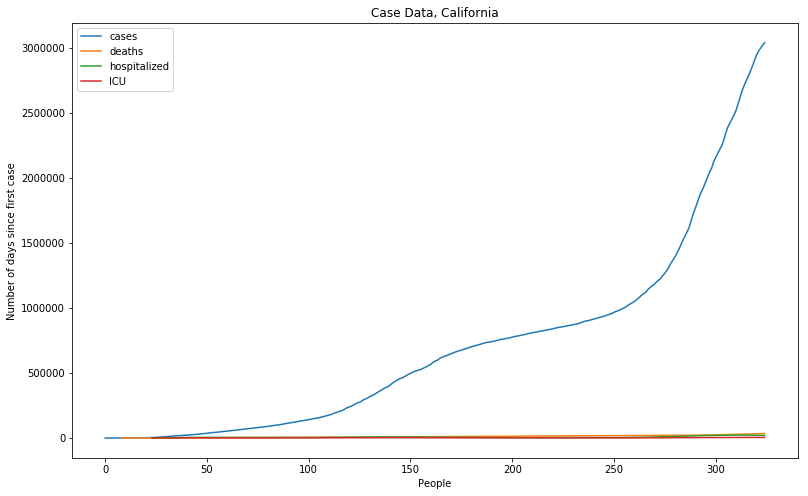

In [26]:
### Fit real data, or work it into my model in some way. 

### make plots  

plt.rcParams['figure.figsize'] = [13, 8]

x = np.linspace(0, len(date), len(date))
# plot raw extracted data 
plt.plot(x, cases, label="cases")
plt.plot(x, deaths, label="deaths")
plt.plot(x, hospital, label="hospitalized")
plt.plot(x, icu, label="ICU")
plt.title("Case Data, California")
plt.xlabel("People")
plt.ylabel("Number of days since first case")
plt.legend()


I did fit k values to this data earlier by using a binning method (see 20210202 notebook)

Based on my 20210202 notebook, 0.017 is actually a more accurate k. This will make the pandemic curve much longer, which is more close to what I actually see in data. I can do the same analysis for the death rate. I saw that ten bins was best, so I will use ten bins to find d. I am copying code out of the referenced notebook. 


324 324
324 324


TypeError: '<' not supported between instances of 'NoneType' and 'int'

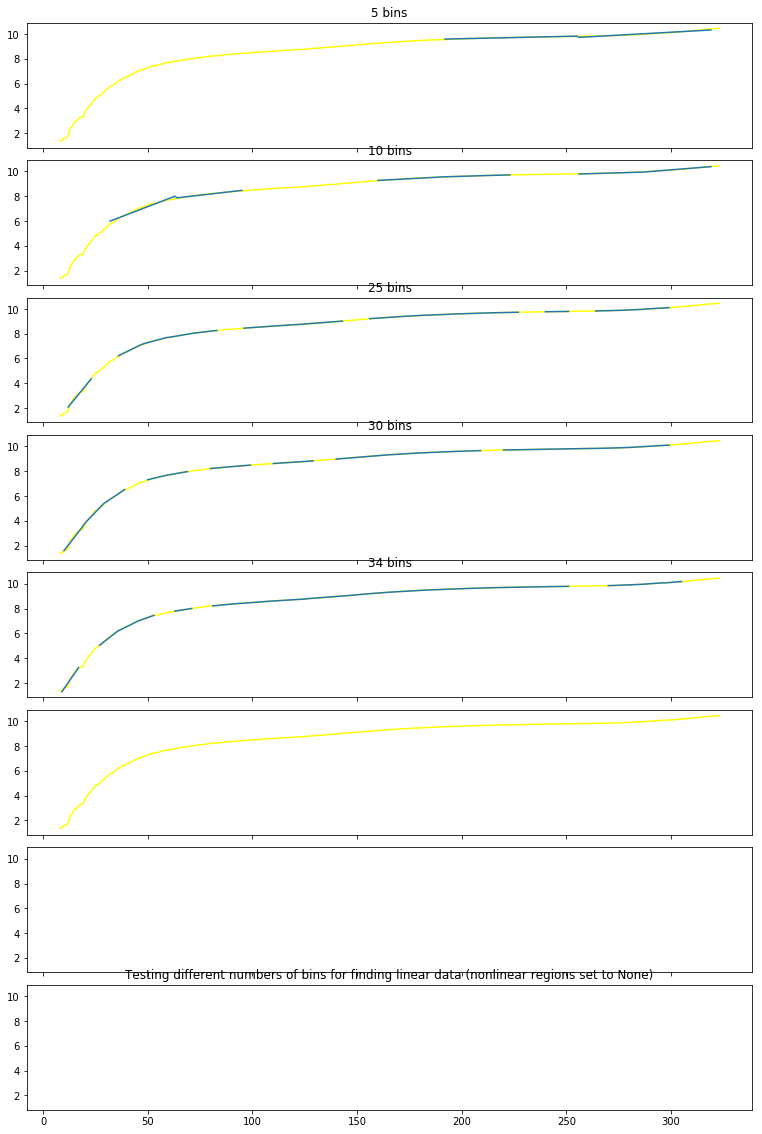

In [27]:
### extract a d value 


def Linearize(time, data, n):
        bin_size = int(len(data)/n) # bin data, analyze chunks in each bin 
        means, stds = [], [] # index mean and standard dev of each chunk
        line, fit = [], [] # index the slopes of each chunk and the linear fit
        chunks = [] # indexed array of each chunk
        for i in range(n):
                bottom = bin_size*i
                top = bottom + bin_size # get index of data chunk
                chunk = data[bottom:top] # chunk of data fills bin 
                chunks.append(chunk)
                if len(chunk) != bin_size: # skip if the bin is not full. keep weights equal
                        continue
                mean = stats.tmean(chunk)
                std = stats.tstd(chunk)
                try: 
                    c=np.polyfit(time[bottom:top], chunk, 1) # linear fit to chunk
                    for j in time[bottom:top]:
                            line.append(c[0]*j+c[1])
                except:
                    c = [None, None]
                    for j in time[bottom:top]:
                        line.append(None)
                stds.append(std)
                fit.append(c) # fit will index the linear formula that best fits that chunk 
                means.append(mean)
        return line, fit, chunks, means, stds
    
def ExtractLinearRegions(chunks, fits, tolerance): # tolerance should be a scalar to apply to where we make the linear cut off
    linearized = [] # store data in linear chunks
    kvals = [] # store k vals. i will index them by linearized chunk
    Residuals = []
    useData = []
    useLine = []
    line = []
    index = []
    xcount = 0
    ChiSq = []
    for i in range(len(chunks)):
        chunk = chunks[i]
        params = fits[i]
        resLocal = 0
        chiSq = 0
        lineLocal = []
        for j in range(len(chunk)):
            if params[0] == None:
                lineLocal.append(None)
                resLocal = None
                xcount = xcount + 1
            else:
                generate = params[0]*xcount + params[1] # get predicted fit, log residuals 
                resNow = generate - chunk[j]
                resLocal = resLocal + resNow
                chiSq = chiSq + (1/generate)*(resNow**2)
                lineLocal.append(generate)
                xcount = xcount+1
        Residuals.append(resLocal)
        line.append(lineLocal)
        ChiSq.append(chiSq)
    NumOnly = []
    for i in Residuals:
        if i != None:
            NumOnly.append(i)
    rangeRes = max(NumOnly) - min(NumOnly) # set toleraence as the bins with residuals that show good fit to line
    for i in range(len(Residuals)):
        chunk = chunks[i]
        l = line[i]
        if Residuals[i] == None:
            Residuals[i] = 99999
        if Residuals[i] < min(Residuals) + rangeRes*tolerance:
            for k in range(len(chunk)):
                useLine.append(l[k])
                useData.append(chunk[k])
        else:
            for k in chunks[i]:
                useData.append(None)
                useLine.append(None)
    return useLine, useData, ChiSq



def LnData(dat):   # I coped this from 20210131 notebook
    lndat = np.zeros(len(dat))
    for i in range(len(dat)):
        try:
            lndat[i] = math.log(dat[i])
        except:
            lndat[i] = None   
    return lndat

# make array for x
x = np.linspace(0, len(date), len(date)+1)
# get ln data
LnDeaths_Raw = LnData(deaths)
LnCases = LnData(cases)

LnDeaths, time = [],[] # need to remove nan values 
for i in range(len(LnDeaths_Raw)): 
    try:
        LnDeaths_Raw[i] * 1
        LnDeaths.append(LnDeaths_Raw[i])
        time.append(x[i])
    except:
        pass

print(len(LnCases), len(LnDeaths))
print(len(cases), len(deaths))
plt.rcParams['figure.figsize'] = [13, 20]
# I will iterate over bin sizes. Ill set tolerance to one standard dev and neighbors to 2. 
bins = [5, 10, 25, 30, 34, 50, 100, 150]

fig1, axs1 = plt.subplots(len(bins), sharex=True,sharey=True, gridspec_kw={'hspace':0.1})
plt.title("Testing different numbers of bins for finding linear data (nonlinear regions set to None)")
for i in range(len(bins)): 
    axs1[i].plot(time, LnDeaths, color = 'yellow')
    line, slopes, chunks, means, stds = Linearize(x, LnDeaths, bins[i])
    useLine, useData, ChiSq = ExtractLinearRegions(chunks, slopes, 0.7)
    axs1[i].plot(time[:len(useData)], useLine)
    axs1[i].set_title(str(bins[i]) +" bins")
plt.title("Linear Regions binning, accepting only bins with similar slopes ")

34 bins gives me the nicest fit of initial conditions. However I should not really leave extraction of k and d to fate. 

In [28]:
### Find least residuals for linear fits 

def ExtractBestFit(ChiSq, slopes): 
    for i in range(len(ChiSq)):
        if ChiSq[i] == 0:
            ChiSq[i] = 999 # remove zeros, these are artifacts
    match = min(ChiSq)
    for i in range(len(ChiSq)):
        if ChiSq[i] == match:
            index = i
            return slopes[i], index
        
bins = [5, 10, 25, 30, 34, 50, 100, 150]

print("FOR DEATH RATE (d)")
for i in range(len(bins)): 
    line, slopes, chunks, means, stds = Linearize(x, LnDeaths, bins[i])
    useLine, useData, ChiSq = ExtractLinearRegions(chunks, slopes, 0.7)
    fit, index = ExtractBestFit(ChiSq, slopes)
    print("For ", bins[i], " bins, the minimum chi square for a linear chunk is: ", min(ChiSq), " corresponding to a slope of: ", fit[0], "for the ", str(index) ,"th bin.") 
            



FOR DEATH RATE (d)
For  5  bins, the minimum chi square for a linear chunk is:  0.0008880372795585494  corresponding to a slope of:  0.00378059427713223 for the  3 th bin.
For  10  bins, the minimum chi square for a linear chunk is:  2.734983734747208e-05  corresponding to a slope of:  0.00274451640234486 for the  7 th bin.
For  25  bins, the minimum chi square for a linear chunk is:  2.057498584673193e-06  corresponding to a slope of:  0.0023378443036255053 for the  20 th bin.
For  30  bins, the minimum chi square for a linear chunk is:  6.995191788357567e-07  corresponding to a slope of:  0.0023404114596873747 for the  25 th bin.
For  34  bins, the minimum chi square for a linear chunk is:  8.277691142834919e-07  corresponding to a slope of:  0.002703608160437507 for the  26 th bin.


TypeError: '<' not supported between instances of 'NoneType' and 'int'

In [29]:
print("\n\nFOR INFECTION RATE (k)")
for i in range(len(bins)): 
    line, slopes, chunks, means, stds = Linearize(x, LnCases, bins[i])
    useLine, useData, ChiSq = ExtractLinearRegions(chunks, slopes, 0.7)
    fit, index = ExtractBestFit(ChiSq, slopes)
    print("For ", bins[i], " bins, the minimum chi square for a linear chunk is: ", min(ChiSq), " corresponding to a slope of: ", fit[0], "for the ", str(index) ,"th bin.") 
            
        



FOR INFECTION RATE (k)
For  5  bins, the minimum chi square for a linear chunk is:  0.00021593173301970783  corresponding to a slope of:  0.004361966018856257 for the  3 th bin.
For  10  bins, the minimum chi square for a linear chunk is:  5.685574129573038e-06  corresponding to a slope of:  0.004087659216452429 for the  6 th bin.
For  25  bins, the minimum chi square for a linear chunk is:  5.720704025926336e-07  corresponding to a slope of:  0.00396208585628472 for the  17 th bin.
For  30  bins, the minimum chi square for a linear chunk is:  1.0564606548634634e-07  corresponding to a slope of:  0.0035363785973343735 for the  22 th bin.
For  34  bins, the minimum chi square for a linear chunk is:  1.9691071175155893e-07  corresponding to a slope of:  0.003765439500428468 for the  23 th bin.
For  50  bins, the minimum chi square for a linear chunk is:  3.732251034039474e-08  corresponding to a slope of:  0.003422521619781919 for the  37 th bin.
For  100  bins, the minimum chi square 

Based on this analysis, I am going to choose ten bins, with 0.7 tolerance, to give me k and d values of k = 0.0041 and d = 0.0028, with a chi square of 5.7E-6 and 2.7E-5 for infections and death rates. 

Now I will plug these into my model. 

In [30]:
plt.rcParams['figure.figsize'] = [13, 8]

/Users/rebeccanishide/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  del sys.path[0]


True


Text(0.5, 0, 'Days Passed')

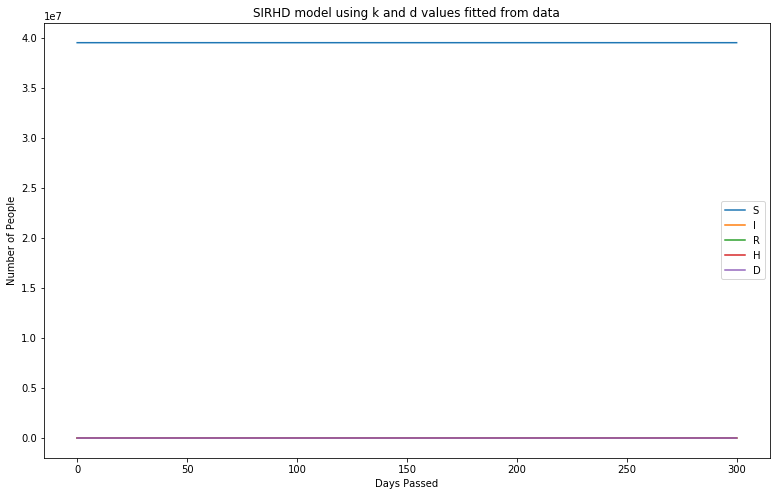

In [33]:
I0 = cases[0]
N = 39.50 * 10 **6
k = 0.0041
g = 1/14
v = N * 0.01
duration = 300
lag = duration + 1# let it run without introducting vaccine 
A = 0
d = 0.0028
dt = 0.01
w = 60
r = 50
time = np.linspace(0, duration, duration/dt)
fig3, axs3 = plt.subplots()
S, I, R, H, D = SIRHD(I0, N, k, g, v, lag, r, A, d, w, dt, duration)
print(CheckTotal(S, I, R, H, D, N))
axs3.plot(time, S, label = "S")
axs3.plot(time, I, label = "I")
axs3.plot(time, R, label = "R")
axs3.plot(time, H, label = "H")
axs3.plot(time, D, label = "D")
#axs3.plot(x[:len(cases)], cases, label = "Real case data")
plt.title("SIRHD model using k and d values fitted from data")
plt.legend()
plt.ylabel("Number of People")
plt.xlabel("Days Passed")


These values basically break my SIR model. 

This is not too suprising since the plot of the cases logarithmically does not really follow the growth we have seen. A simple way to check this will be solving for k knowing the first and last number of cases in the data set, and the time window. I can fit a function between them and see what k i get for that. 


In [34]:
FirstDay = cases[0]
Days = len(cases)
LastDay = cases[Days-1]


def FitFunction(first, last, days):  # I want to fit to I(t) = I0*e**(kt)
    I0 = first
    k = (1/(days-1))*(math.log(last/first))
    return k

e = (1+(1/(1000000)))**1000000

def FittedFunction(I0, k, days):
    out = []
    for i in range(days):
        y = I0*e**(k*i)
        out.append(y)
    return out

k_test = FitFunction(FirstDay,LastDay, Days)
print("Just fitting the first and last points to an exponential growth function, I get k =", k_test)



Just fitting the first and last points to an exponential growth function, I get k = 0.03392186265228748


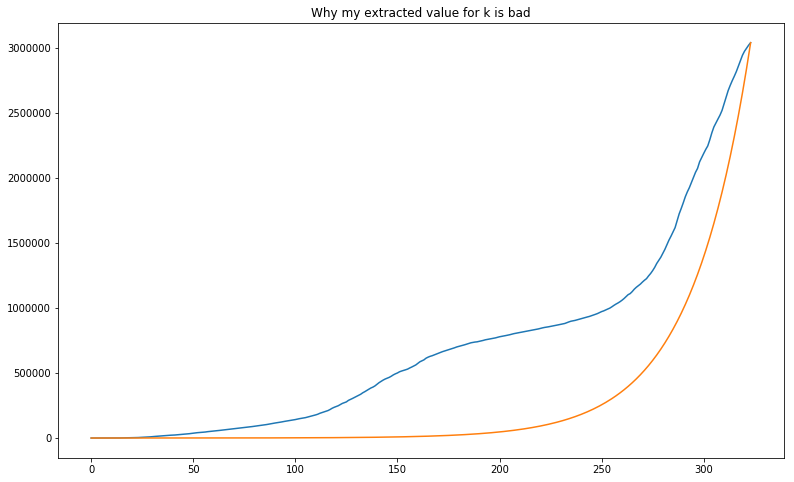

In [35]:
### Check this k

fig4, axs4 = plt.subplots()
axs4.plot(x[:len(cases)], cases)
plt.title("Why my extracted value for k is bad")
axs4.plot(x[:Days], FittedFunction(FirstDay, k_test, Days))


### [RN] 4:34
Obviously the approach we learned in lab for fitting k is not a godo one fir this situation. There is not really any region in which it will give an accurate k value that is actually practical to use with the SIR model because the SIR model is basically just not very good. 

For deaths, it will make more sense to just average over the number of cases than to track the deaths with exponential growth over time (this is because the deaths shadow the cases to a less extreme rise over time). 

I will basically just divide total cases from day 0 to 14 days before the end of the data set by total deaths to get a rough estimate of the percent of infected people that die, assuming that it may take up to 14 days for death tolls to reflect ifection rates. 


In [36]:
def Sum(data):
    scrubbed = []
    for i in data:
        if i != None:
            scrubbed.append(i)
    return sum(scrubbed)
TotalDeaths = Sum(deaths)
TotalInfections = Sum(cases)
AvgDeathRate = TotalDeaths*(1/TotalInfections)

print("The average death rate is ", AvgDeathRate, " percent of infections.")

The average death rate is  0.016095815786302994  percent of infections.


Now i can plug these numbers into my model. 

/Users/rebeccanishide/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  del sys.path[0]


True


Text(0.5, 0, 'Days Passed')

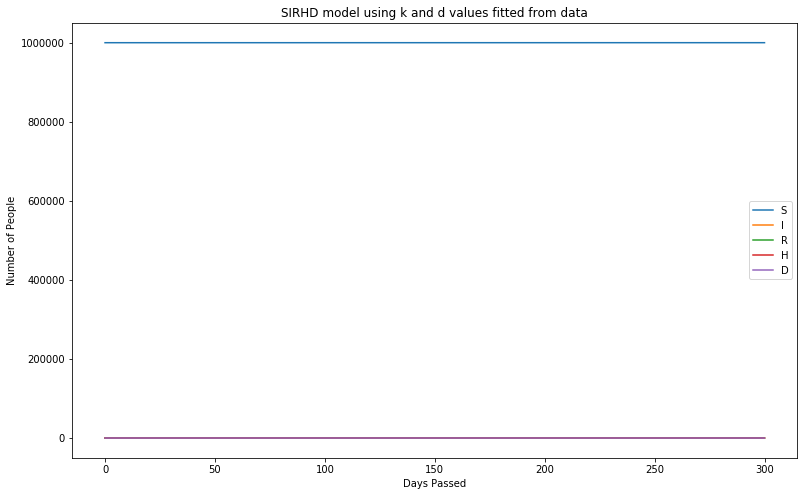

In [37]:
I0 = cases[0]
N = 1000000
k = 0.034
g = 1/14
v = N * 0.01
duration = 300
lag = duration + 1# let it run without introducting vaccine 
A = 0
d = 0.0016
dt = 0.01
w = 60

time = np.linspace(0, duration, duration/dt)
fig5, axs5 = plt.subplots()
S, I, R, H, D = SIRHD(I0, N, k, g, v, lag, r, A, d, w, dt, duration)
print(CheckTotal(S, I, R, H, D, N))
axs5.plot(time, S, label = "S")
axs5.plot(time, I, label = "I")
axs5.plot(time, R, label = "R")
axs5.plot(time, H, label = "H")
axs5.plot(time, D, label = "D")
#axs3.plot(x[:len(cases)], cases, label = "Real case data")
plt.title("SIRHD model using k and d values fitted from data")
plt.legend()
plt.ylabel("Number of People")
plt.xlabel("Days Passed")


Still breaks my model. Lets try this k with the basic SIR. 

324 324


/Users/rebeccanishide/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  del sys.path[0]


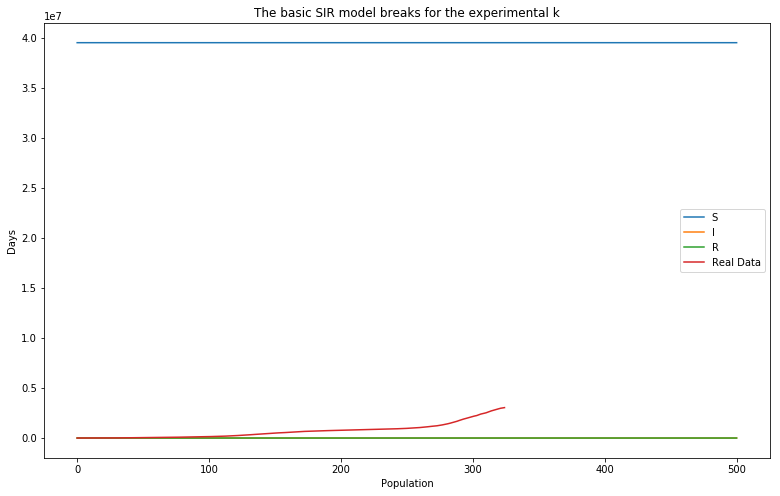

In [38]:
## try with basic sir



N = 39.5*10**6
duration = 500 
k = 0.034
dt = 0.01
S, I, R = SIR(I0, N, k, g, dt, duration)
g = 1/14

time = np.linspace(0, len(cases), len(cases))
x = np.linspace(0, duration, duration/dt)
print(len(time), len(cases))
fig6, axs6 = plt.subplots()
axs6.plot(x[:len(S)], S, label = "S")
axs6.plot(x[:len(S)], I, label = "I")
axs6.plot(x[:len(S)], R, label = "R")
axs6.plot(time, cases, label = "Real Data")
plt.xlabel("Population")
plt.ylabel("Days")
plt.title("The basic SIR model breaks for the experimental k")
plt.legend()

### [RN] 4:54

It seems like the SIR model really just does not work for what our intent was given the real data. 

I will try again fitting the first few days. I will iterate over different time windows to see how it changes. 

I am basically doing initial steady state studies. I will call this window the ISS (initial steady state). time

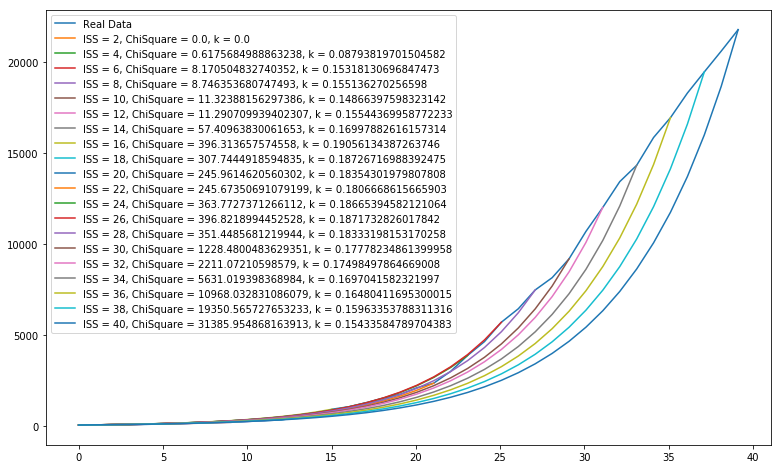

In [39]:
### Try getting k from first few days 
ISS = []
ISS_k = []
for i in range(1,21):
    ISS.append(2*i)
    
for i in ISS: 
    FirstDay = cases[0]
    Days = i
    LastDay = cases[Days-1]
    k = FitFunction(FirstDay,LastDay, Days)
    ISS_k.append(k)
    
fig7, axs7 = plt.subplots()
axs7.plot(time[:max(ISS)], cases[:max(ISS)], label  = "Real Data")
for i in range(len(ISS_k)):
    Fit = FittedFunction(FirstDay, ISS_k[i], ISS[i])
    ChiSq = 0
    for j in range(len(Fit)):
        deviation = abs(cases[j] - Fit[j])
        ChiSq = (deviation**2)*(1/cases[j]) + ChiSq
    axs7.plot(time[:ISS[i]], Fit, label = "ISS = " + str(ISS[i]) + ", ChiSquare = " + str(ChiSq) + ", k = " + str(ISS_k[i]))
plt.legend()

# Check residuals from ISS fit to data



### [RN] 5:08

After 12 days, the chi square really jumps up and k changes significantly. I will use ISS is 12 days, so k = 0.15. This finally gives me a R0 value of about 2 using g = 1/14, whearas others were way below 1, which is why the model broke. I will keep that deat rate of 0.016 of infections

/Users/rebeccanishide/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


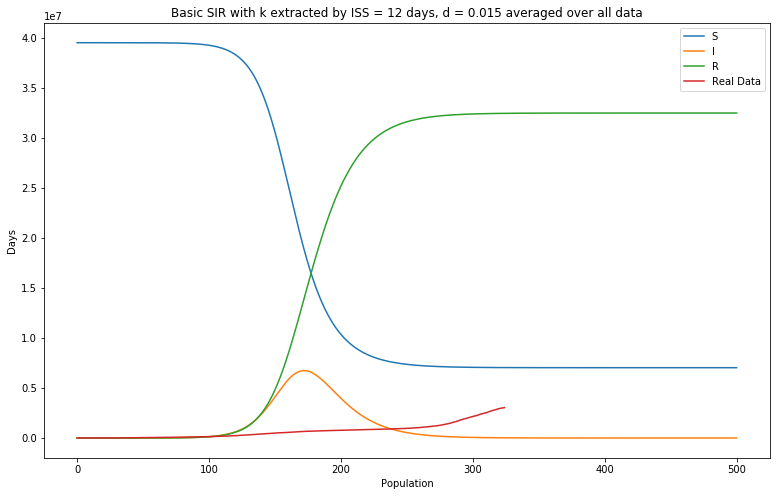

In [40]:
### Final plots? hopefully 

I0 = cases[0]
N = 39.5*10**6 # actual population of CA
k = 0.15
g = 1/14
v = N * 0.01
duration = 500 
lag = duration + 1# let it run without introducting vaccine 
A = 0
d = 0.016
dt = 0.01
w = 60

fig8, axs8 = plt.subplots()
S, I, R = SIR(I0, N, k, g, dt, duration)
time = np.linspace(0, len(cases), len(cases))
x = np.linspace(0, duration, duration/dt)


axs8.plot(x[:len(S)], S, label = "S")
axs8.plot(x[:len(S)], I, label = "I")
axs8.plot(x[:len(S)], R, label = "R")
axs8.plot(time, cases, label = "Real Data")
plt.xlabel("Population")
plt.ylabel("Days")
plt.title("Basic SIR with k extracted by ISS = 12 days, d = 0.015 averaged over all data")
plt.legend()

Still looks terrible. lets try my model, and introducing the vaccine at 200 days in, where v is 0.01% of population. 

/Users/rebeccanishide/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


True


Text(0.5, 0, 'Days Passed')

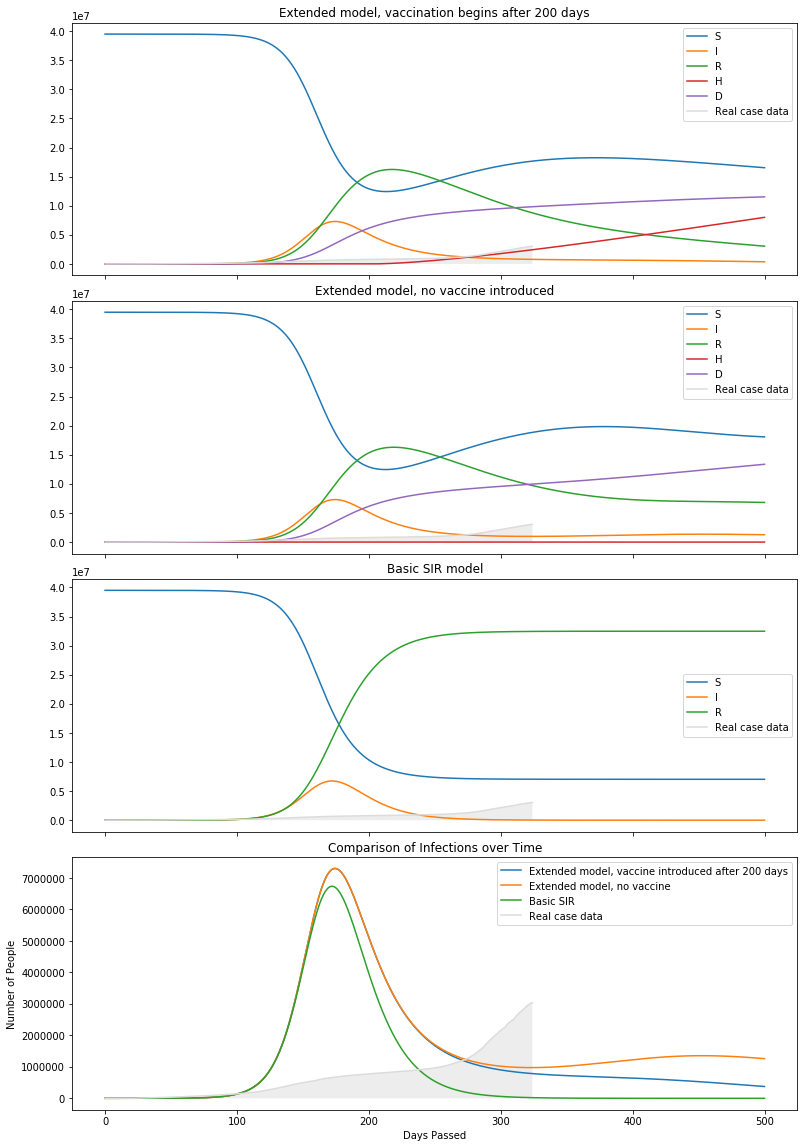

In [41]:
v = N * 0.001 # assume at max capacity 0.01 percent of population will be vaccinated a day. 
lag = 200 # takes 200 days to develop and start giving out vaccines
r = 50 # takes 50 days to give vaccines at half threshold they will evantually maximally be given 
w = 90 # person loses immunity to infections 90 days after recovering
plt.rcParams['figure.figsize'] = [13, 20]
x = np.linspace(0, duration, duration/dt)
A = 0.01 # assume one percent of population will never be properly vaccinated

fig9, axs9 = plt.subplots(4, sharex=True, gridspec_kw={'hspace':0.1}) # plot the models


S, I, R, H, D = SIRHD(I0, N, k, g, v, lag, r, A, d, w, dt, duration)
print(CheckTotal(S, I, R, H, D, N))
axs9[0].plot(x, S, label = "S")
axs9[0].plot(x, I, label = "I")
axs9[0].plot(x, R, label = "R")
axs9[0].plot(x, H, label = "H")
axs9[0].plot(x, D, label = "D")
axs9[3].plot(x, I, label = "Extended model, vaccine introduced after "+ str(lag) + " days")
axs9[0].plot(time[:len(cases)], cases, label = "Real case data", color = "gainsboro")
axs9[0].fill_between(time[:len(cases)], 0, cases, facecolor = "gainsboro", alpha = 0.5)
axs9[0].set_title("Extended model, vaccination begins after "+ str(lag) + " days")
axs9[0].legend()

lag = 900
S, I, R, H, D = SIRHD(I0, N, k, g, v, lag, r, A, d, w, dt, duration)
axs9[1].plot(x, S, label = "S")
axs9[1].plot(x, I, label = "I")
axs9[1].plot(x, R, label = "R")
axs9[1].plot(x, H, label = "H")
axs9[1].plot(x, D, label = "D")
axs9[3].plot(x, I, label = "Extended model, no vaccine")
axs9[1].plot(time[:len(cases)], cases, label = "Real case data", color = "gainsboro")
axs9[1].fill_between(time[:len(cases)], 0, cases, facecolor = "gainsboro", alpha = 0.5)
axs9[1].set_title("Extended model, no vaccine introduced")
axs9[1].legend()

S, I, R = SIR(I0, N, k, g, dt, duration)
axs9[2].plot(x, S, label = "S")
axs9[2].plot(x, I, label = "I")
axs9[2].plot(x, R, label = "R")
axs9[2].plot(time[:len(cases)], cases, label = "Real case data", color = "gainsboro")
axs9[2].fill_between(time[:len(cases)], 0, cases, facecolor = "gainsboro", alpha = 0.5)
axs9[2].set_title("Basic SIR model")
axs9[2].legend()
axs9[3].plot(x, I, label = "Basic SIR")

axs9[3].set_title("Comparison of Infections over Time")
axs9[3].plot(time[:len(cases)], cases, label = "Real case data", color = "gainsboro")
axs9[3].fill_between(time[:len(cases)], 0, cases, facecolor = "gainsboro", alpha = 0.5)
axs9[3].legend()

plt.ylabel("Number of People")
plt.xlabel("Days Passed")




## HIT
### [RN] 6:03 
Finally, I want to make an algorithm that extracts the HIT point for herd immunity, or the H threshold at which the infection rate changes such that the infected population will eventually be zero. 

I will test different vaccination rates and different times at which the vaccine is introduced. 

10
True


ValueError: x and y must have same first dimension, but have shapes (325,) and (50000,)

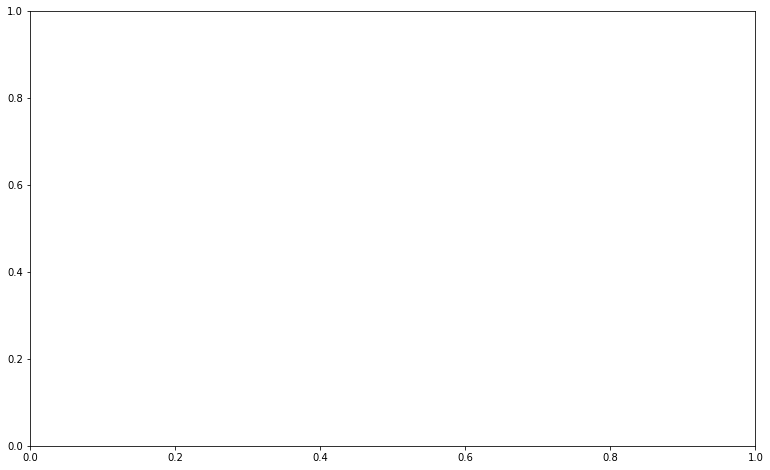

In [20]:
### Test different vaccination capacity 

I0 = cases[0]
N = 3.95*10**6 # actual population of CA
k = 0.15
g = 1/14
v = [10, 1, 0.1, 0.01, 0.001]
r = 50
duration = 500 
lag = 100
A = 0
d = 0.016
dt = 0.01
w = 60

plt.rcParams['figure.figsize'] = [13, 8]

fig10, axs10 = plt.subplots(1, sharex=True, gridspec_kw={'hspace':0.1}) # plot the models

for i in range(len(v)):
    print(v[i])
    S, I, R, H, D = SIRHD(I0, N, k, g, v[i]*N, lag, r, A, d, w, dt, duration)
    print(CheckTotal(S, I, R, H, D, N))
    axs10.plot(x, I, label = "Infections, v=" + str(v[i]))
    
    
axs10.plot(time[:len(cases)], cases, label = "Real case data", color = "gainsboro")
axs10.fill_between(time[:len(cases)], 0, cases, facecolor = "gainsboro", alpha = 0.5)
axs10.legend()
plt.title("Vaccination at varied max capacities, introduced after " + str(lag) + " days, r=" + str(r))
plt.xlabel("Number of People")
plt.xlabel("Days Elapsed")

1
True
5
True
10
True
25
True
50
True
100
True


Text(0.5, 0, 'Days Elapsed')

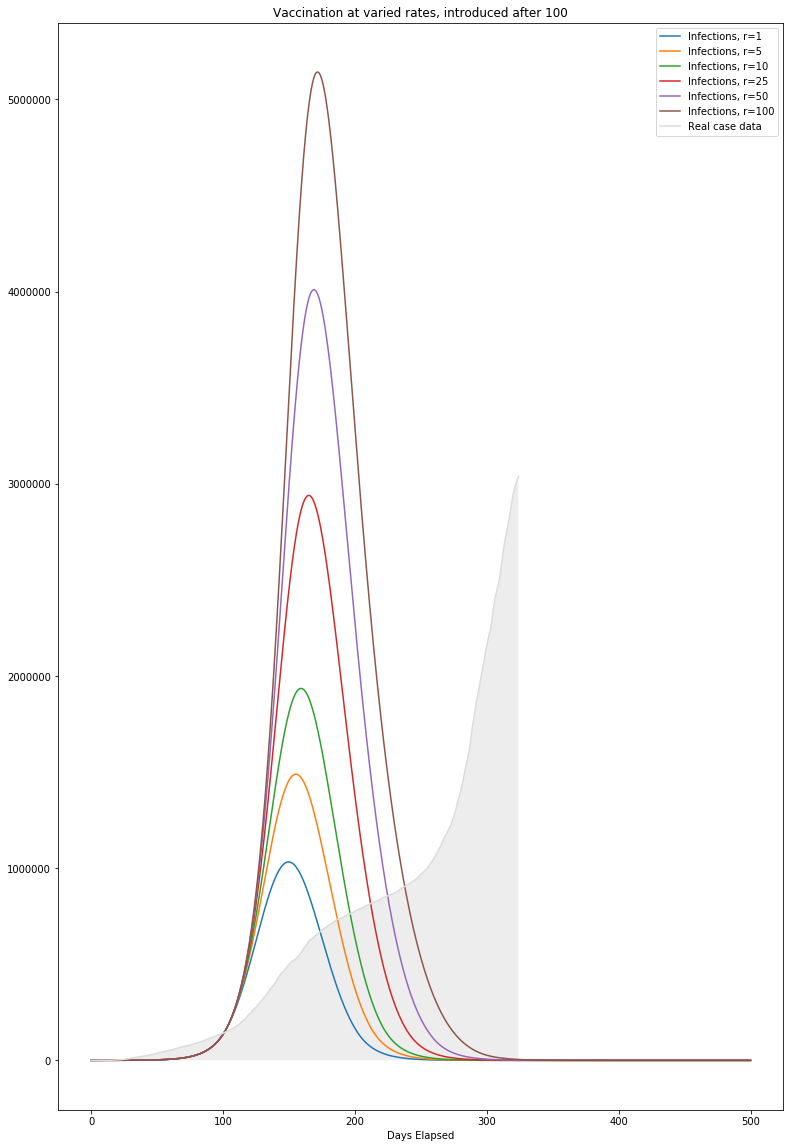

In [42]:
### Test different vaccination rates 

I0 = cases[0]
N = 39.5*10**6 # actual population of CA
k = 0.15
g = 1/14
v = 0.01 * N
r = [1, 5, 10, 25, 50, 100]
duration = 500 
lag = 100
A = 0
d = 0.016
dt = 0.01
w = 60


fig11, axs11 = plt.subplots(1, sharex=True, gridspec_kw={'hspace':0.1}) # plot the models

for i in range(len(r)):
    print(r[i])
    S, I, R, H, D = SIRHD(I0, N, k, g, v, lag, r[i], A, d, w, dt, duration)
    print(CheckTotal(S, I, R, H, D, N))
    axs11.plot(x, I, label = "Infections, r=" + str(r[i]))
axs11.plot(time[:len(cases)], cases, label = "Real case data", color = "gainsboro")
axs11.fill_between(time[:len(cases)], 0, cases, facecolor = "gainsboro", alpha = 0.5)   
axs11.legend()
plt.title("Vaccination at varied rates, introduced after " + str(lag))
plt.xlabel("Number of People")
plt.xlabel("Days Elapsed")

The rate of vaccination rollout seems to lower the total number of people infected at a time with a small effect on width of curve. The total capacity for vaccination further shifts the day of peak infections closer to the rollout date, and stops the spread earlier. 

1
True
25
True
50
True
100
True
250
True
500
True


Text(0.5, 0, 'Days Elapsed')

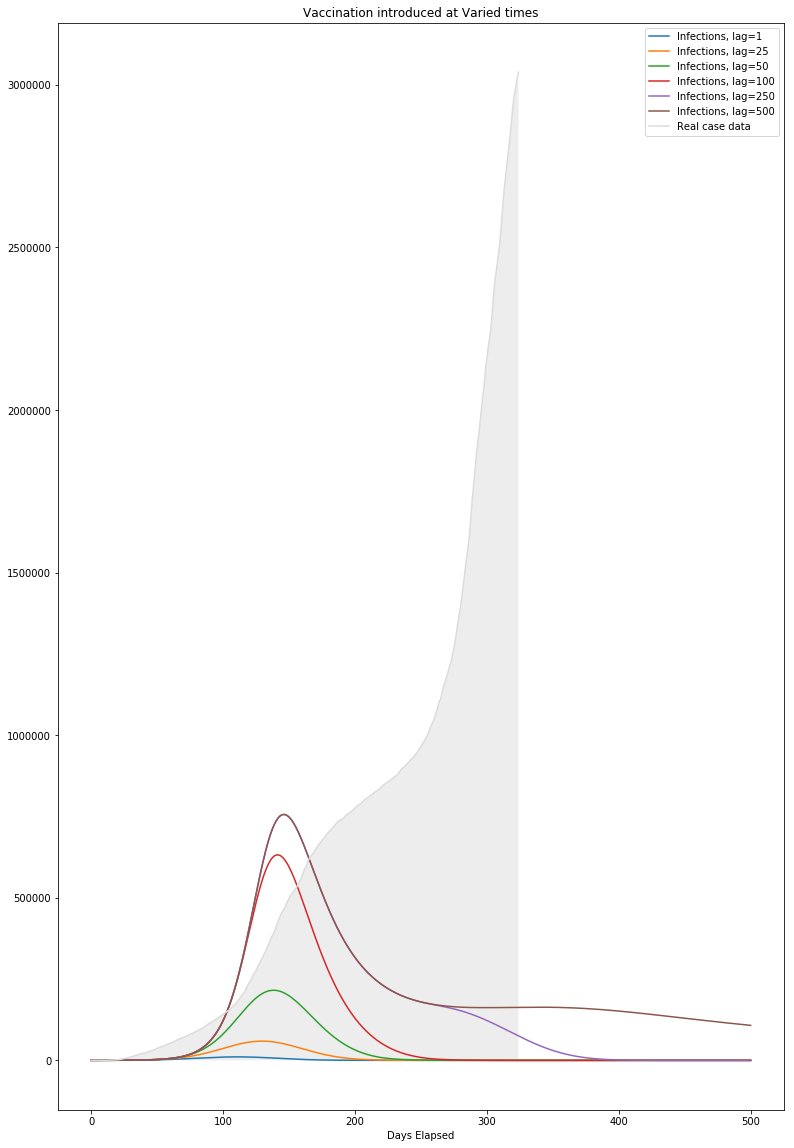

In [43]:
### Test different vaccination lags

I0 = cases[0]
N = 3.95*10**6 # actual population of CA
k = 0.15
g = 1/14
v = 0.01*N
r = 50
duration = 500 
lag = [1, 25, 50, 100, 250, 500]
A = 0
d = 0.016
dt = 0.01
w = 60


fig12, axs12 = plt.subplots(1, sharex=True, gridspec_kw={'hspace':0.1}) # plot the models

for i in range(len(lag)):
    print(lag[i])
    S, I, R, H, D = SIRHD(I0, N, k, g, v, lag[i], r, A, d, w, dt, duration)
    print(CheckTotal(S, I, R, H, D, N))
    axs12.plot(x, I, label = "Infections, lag=" + str(lag[i]))
    
    
axs12.plot(time[:len(cases)], cases, label = "Real case data", color = "gainsboro")
axs12.fill_between(time[:len(cases)], 0, cases, facecolor = "gainsboro", alpha = 0.5)
axs12.legend()
plt.title("Vaccination introduced at Varied times")
plt.xlabel("Number of People")
plt.xlabel("Days Elapsed")

Unsuprisingly, early rollout minimizws cases. Rollout later in the pandemic, post maxumum cases, is still beneficial becuase it makes the tail end of the curve to to zero rather than reach a somewhat steadystate. 

I want to be able to define HIT just as a population percent. This basically means there are enough people vaccinated that the infection rate is forced to die out. The differentials for S, I, H, and R are:

$\frac{dS(t)}{dt} = -k\frac{S(t)}{N}I(t) - v(t)\left(\frac{S(t)}{R(t) + S(t)}\right) + \frac{1}{w}R(t)$


$\frac{dI(t)}{dt} = k\frac{S(t)}{N}I(t)-gI(t)$

$\frac{dR(t)}{dt} = gI(t)-D(t)-v(t)\left(\frac{R(t)}{R(t) + S(t)}\right) - \frac{1}{w}R(t)$


$\frac{dH(t)}{dt} = \begin{cases}
    H(t) + v(t)\left(R(t) + S(t)\right), & t > lag \\
    0, & t < lag
    \end{cases}$ 

so when $\frac{k}{N}S(T$) is always much smaller than g, cases are always decreasing. The rate of adding recovered people back cannot be allowed to compensate as well. We should also have some tolerance for k getting bigger. 

After time T, 



I think we can define HIT as the interesction of H and I, but I do not really have mathematical proof. 

/Users/rebeccanishide/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


True
0.0
50000 50000
True
0.0
50000 50000
True
13166666.666666668
50000 50000
True
20690476.19047619
50000 50000
True
23700000.0
50000 50000
True
26333333.333333336
50000 50000


Text(0.5, 0, 'Days Elapsed')

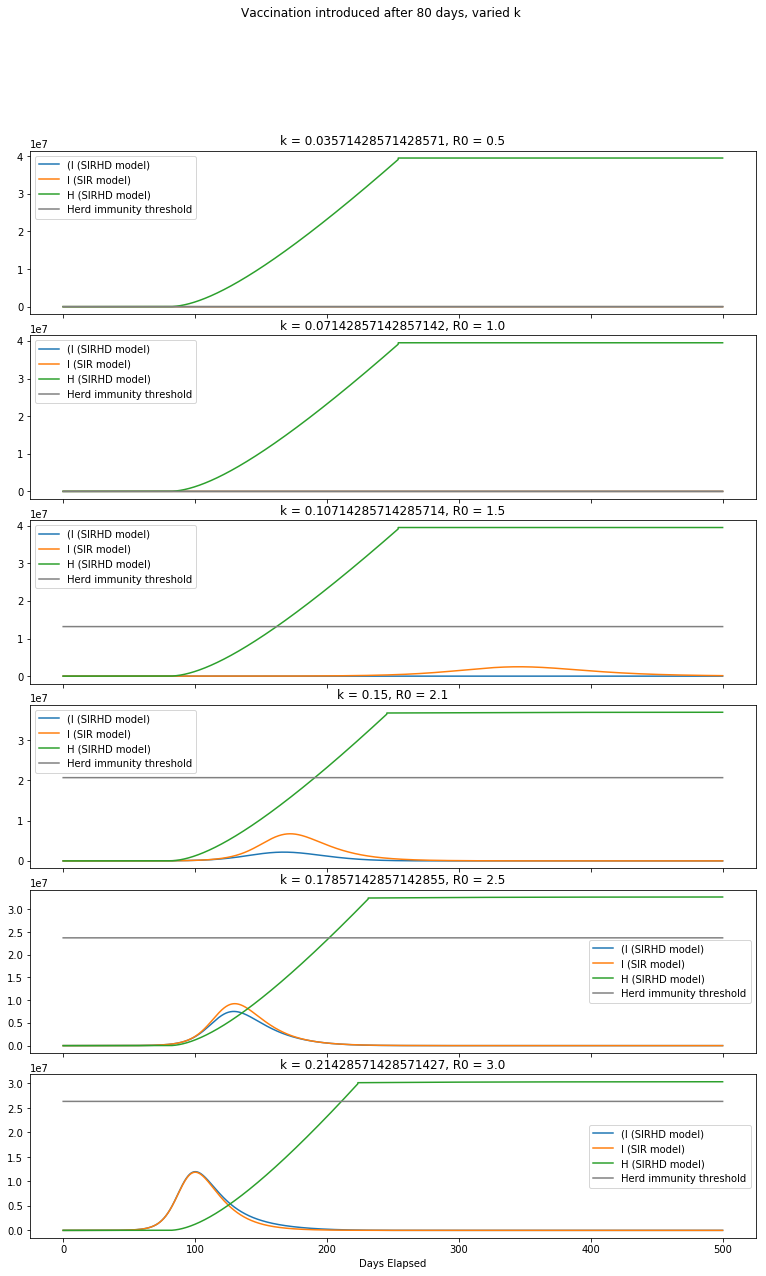

In [75]:
### plot different k values 

### Test different vaccination lags

I0 = cases[0]
N = 39.5*10**6 # actual population of CA
k = [0.5*g, g , 1.5*g, 0.15, 2.5*g, 3*g]
g = 1/14
v = 0.01*N
r = 50
duration = 500 
lag = 80
A = 0
d = 0.016
dt = 0.01
w = 90
x = np.linspace(0, duration, duration/dt)
plt.rcParams['figure.figsize'] = [13, 20]

fig13, axs13 = plt.subplots(len(k), sharex=True, gridspec_kw={'hspace':0.13}) # plot the models

for i in range(len(k)):
    S, I, R, H, D = SIRHD(I0, N, k[i], g, v, lag, r, A, d, w, dt, duration)
    print(CheckTotal(S, I, R, H, D, N))
    axs13[i].set_title("k = " + str(k[i]) + ", R0 = " + str(round(k[i]/g, 1)))
    axs13[i].plot(x, I, label = "(I (SIRHD model)")
    S, I, R = SIR(I0, N, k[i], g, dt, duration)
    HIT = 1 - (g/k[i])
    if HIT < 0: 
        HIT = 0
    HIT_line = []
    for j in range(len(x)):
        HIT_line.append(HIT*N)
    print(HIT*N)
    print(len(HIT_line), len(x))
    axs13[i].plot(x, I, label = "I (SIR model)")
    axs13[i].plot(x, H, label = "H (SIRHD model)")
    axs13[i].plot(x, HIT_line, label = "Herd immunity threshold", color = "grey")
    axs13[i].legend()
    

fig13.suptitle("Vaccination introduced after " + str(lag) + " days, varied k")
plt.xlabel("Number of People")
plt.xlabel("Days Elapsed")


